tgb - 2/22/2019 - The goal is to reproduce the R2 scores plots from the original GRL paper about NNCAM
Here, I am mostly following https://github.com/raspstephan/CBRAIN-CAM/blob/master/notebooks/presentation/grl_paper.ipynb and the networks are defined and trained in https://github.com/tbeucler/CBRAIN-CAM/blob/master/notebooks/tbeucler_devlog/005_Predicting_convective_and_radiative_heating_profiles.ipynb

# 1) Load the neural networks

## 1.1) Import modules

In [1]:
#!ln -s /filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/cbrain \
#/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain
from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.models import *
from cbrain.losses import *
from cbrain.utils import limit_mem
import tensorflow as tf
import tensorflow.math as tfm
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import xarray as xr
import numpy as np
# Otherwise tensorflow will use ALL your GPU RAM for no reason
limit_mem()
TRAINDIR = '/local/Tom.Beucler/SPCAM_PHYS/'
DATADIR = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/sp32fbp_andkua/'
PREFIX = '32_col_rad_12m_'
%cd /filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM

/home/t/Tom.Beucler/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM


## 1.2) Directly load conserving and unconstrained networks

In [2]:
%cd $TRAINDIR/HDF5_DATA
!pwd
C_rad_5dens = load_model('C_rad_5dens.h5')
U_rad_5dens = load_model('U_rad_5dens.h5')

/data/Tom.Beucler/SPCAM_PHYS/HDF5_DATA
/data/Tom.Beucler/SPCAM_PHYS/HDF5_DATA


## 1.3) Define the weakly-constrained models then load weights
tgb - 2/22/2019 - The custom loss function did not save properly so I am redefining the custom loss function, the model and then loading the weights of the trained networks.

### 1.3.1) Define custom loss function

In [4]:
def customLoss(input_tensor,fsub,fdiv,normq,hyai,hybi,alpha = 0.5):

        # tgb - 2/5/2019 - Loss function written above
    def lossFunction(y_true,y_pred):    
        loss = tfm.multiply(alpha, mse(y_true, y_pred))
        loss += tfm.multiply(tfm.subtract(1.0,alpha), \
                            massent_res(input_tensor,y_pred,fsub,fdiv,normq,hyai,hybi))
        return loss

    # tgb - 2/5/2019 - Mass and enthalpy residual function
    # Adapted from massent_check by converting numpy to tensorflow
    def massent_res(x,y,fsub,fdiv,normq,hyai,hybi):

        # 0) Constants
        G = 9.80616; # Reference gravity constant [m.s-2]
        L_F = 3.337e5; # Latent heat of fusion of water [W.kg-1]
        L_V = 2.501e6; # Latent heat of vaporization of water [W.kg-1]
        L_S = L_F+L_V; # Latent heat of sublimation of water [W.kg-1]
        P0 = 1e5; # Reference surface pressure [Pa]   

        # WATER&ENTHALPY) Get non-dimensional pressure differences (p_tilde above)
        # In the input vector, PS is the 151st element after 
        # the first elements = [QBP, ..., VBP with shape 30*5=150]
        PS = tfm.add( tfm.multiply( x[:,300], fdiv[300]), fsub[300])
        # Reference for calculation of d_pressure is cbrain/models.py (e.g. QLayer)
        P = tfm.add( tfm.multiply( P0, hyai), \
        tfm.multiply( PS[:,None], hybi))
        dP = tfm.subtract( P[:, 1:], P[:, :-1])
        # norm_output = dp_norm * L_V/G so dp_norm = norm_output * G/L_V
        dP_NORM = tfm.divide( \
        tfm.multiply(normq[:30], \
                  G),\
        L_V)
        # dp_tilde = dp/dp_norm
        dP_TILD = tfm.divide( dP, dP_NORM)

        # WATER.1) Calculate water vertical integral from level 1 to level 30
        WATVEC = tfm.multiply( dP_TILD, tfm.add(tfm.add(y[:, :30],\
                                                        y[:, 30:60]),\
                                                y[:, 60:90]))
        WATINT = tfm.reduce_sum( WATVEC, axis=1)

        # WATER.2) Calculate forcing on the right-hand side (Net Evaporation-Precipitation)
        # E-P is already normalized to units W.m-2 in the output vector
        # so all we need to do is input-unnormalize LHF that is taken from the input vector
        LHF = tfm.add( tfm.multiply( x[:,303], fdiv[303]), fsub[303])
        # Note that total precipitation = PRECT + 1e-3*PRECTEND in the CAM model
        # PRECTEND already multiplied by 1e-3 in output vector so no need to redo it
        PREC = tfm.add( y[:, 214], y[:, 215])

        # WATER.FINAL) Residual = E-P-DWATER/DT
        WATRES = tfm.add(tfm.add(LHF,\
                                 tfm.negative(PREC)),\
                         tfm.negative(WATINT))

        # ENTHALPY.1) Calculate net energy input from phase change and precipitation
        # PHAS = Lf/Lv*((PRECST+PRECSTEN)-(PRECT+PRECTEND))
        PHAS = tfm.divide( tfm.multiply( tfm.subtract(\
                                              tfm.add( y[:,216], y[:,217]),\
                                              tfm.add( y[:,214], y[:,215])),\
                                      L_F),\
                         L_V)

        # ENTHALPY.2) Calculate net energy input from radiation, sensible heat flux and turbulent KE
        # 2.1) RAD = FSNT-FSNS-FLNT+FLNS
        RAD = tfm.add(\
                      tfm.subtract( y[:,210], y[:,211]),\
                      tfm.subtract( y[:,213], y[:,212]))
        # 2.2) Unnormalize sensible heat flux
        SHF = tfm.add( tfm.multiply( x[:,302], fdiv[302]), fsub[302])
        # 2.3) Net turbulent kinetic energy dissipative heating is the column-integrated 
        # turbulent kinetic energy energy dissipative heating
        KEDVEC = tfm.multiply( dP_TILD, y[:, 120:150])
        KEDINT = tfm.reduce_sum( KEDVEC, axis=1)

        # ENTHALPY.3) Calculate tendency of normalized column water vapor due to phase change
        # 3.1) Column water vapor is the column integral of specific humidity
        PHQVEC = tfm.multiply( dP_TILD, y[:, :30])
        PHQINT = tfm.reduce_sum( PHQVEC, axis=1)
        # 3.2) Multiply by L_S/L_V to normalize (explanation above)
        SPDQINT = tfm.divide( tfm.multiply( tfm.subtract(\
                                                     PHQINT, LHF),\
                                        L_S),\
                           L_V)

        # ENTHALPY.4) Same operation for liquid water tendency but multiplied by L_F/L_V
        SPDQCINT = tfm.divide( tfm.multiply(\
                                      tfm.reduce_sum(\
                                             tfm.multiply( dP_TILD, y[:, 30:60]),\
                                             axis=1),\
                                      L_F),\
                         L_V)

        # ENTHALPY.5) Same operation for temperature tendency
        DTINT = tfm.reduce_sum( tfm.multiply( dP_TILD[:, :30], y[:, 90:120]), axis=1)

        # ENTHALPY.FINAL) Residual = SPDQ+SPDQC+DTINT-RAD-SHF-PHAS
        ENTRES = tfm.add(tfm.add(tfm.add(tfm.add(tfm.add(tfm.add(SPDQINT,\
                                                                 SPDQCINT),\
                                                         DTINT),\
                                                 tfm.negative(RAD)),\
                                         tfm.negative(SHF)),\
                                 tfm.negative(PHAS)),\
                         tfm.negative(KEDINT))
        # Return sum of water and enthalpy square residuals
        return tfm.add( tfm.square(WATRES), tfm.square(ENTRES))

    return lossFunction

### 1.3.2) Define weakly-constrained model

In [5]:
# Weakly-constrained models with 5 dense layers
# alpha=0.01
inp001 = Input(shape=(304,))
densout = Dense(512, activation='linear')(inp001)
densout = LeakyReLU(alpha=0.3)(densout)
for i in range (4):
    densout = Dense(512, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
densout = Dense(218, activation='linear')(densout)
out = LeakyReLU(alpha=0.3)(densout)
W001_rad_5dens = Model(inputs=inp001, outputs=out)
# alpha=0.5
inp05 = Input(shape=(304,))
densout = Dense(512, activation='linear')(inp05)
densout = LeakyReLU(alpha=0.3)(densout)
for i in range (4):
    densout = Dense(512, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
densout = Dense(218, activation='linear')(densout)
out = LeakyReLU(alpha=0.3)(densout)
W05_rad_5dens = Model(inputs=inp05, outputs=out)
# alpha=0.99
inp099 = Input(shape=(304,))
densout = Dense(512, activation='linear')(inp099)
densout = LeakyReLU(alpha=0.3)(densout)
for i in range (4):
    densout = Dense(512, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
densout = Dense(218, activation='linear')(densout)
out = LeakyReLU(alpha=0.3)(densout)
W099_rad_5dens = Model(inputs=inp099, outputs=out)

### 1.3.3) Load normalization files and compile weakly-constrained model with custom loss function

In [7]:
# 1) Open the file containing the normalization of the targets
ds = xr.open_dataset(TRAINDIR + PREFIX + 'train_norm.nc')
# 2) Open the pickle files containing the pressure converters
with open(os.path.join('/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/cbrain', 'hyai_hybi.pkl'), 'rb') as f:
            hyai, hybi = pickle.load(f)
# 3) Define fsub, fdiv, normq
fsub = ds.feature_means.values
fdiv = ds.feature_stds_by_var.values
normq = ds.target_conv.values
print('fsub.shape=',fsub.shape)
print('fdiv.shape=',fdiv.shape)
print('normq.shape=',normq.shape)
print('hyai.shape=',hyai.shape)
print('hybi.shape=',hybi.shape)

ds.close()

fsub.shape= (304,)
fdiv.shape= (304,)
normq.shape= (218,)
hyai.shape= (31,)
hybi.shape= (31,)


In [8]:
W001_rad_5dens.compile(loss=customLoss(inp001,fsub,fdiv,normq,hyai,hybi,alpha = 0.01),\
                       optimizer='rmsprop')
W05_rad_5dens.compile(loss=customLoss(inp05,fsub,fdiv,normq,hyai,hybi,alpha = 0.5),\
                       optimizer='rmsprop')
W099_rad_5dens.compile(loss=customLoss(inp099,fsub,fdiv,normq,hyai,hybi,alpha = 0.99),\
                       optimizer='rmsprop')

### 1.3.4) Load neural network weights

In [9]:
%cd $TRAINDIR/HDF5_DATA
!pwd
W001_rad_5dens.load_weights('W001_rad_5dens.h5')
W05_rad_5dens.load_weights('W05_rad_5dens.h5')
W099_rad_5dens.load_weights('W099_rad_5dens.h5')

/data/Tom.Beucler/SPCAM_PHYS/HDF5_DATA
/data/Tom.Beucler/SPCAM_PHYS/HDF5_DATA


# 2) Geographical figures

## 2.1) Define coordinates, variables and units

In [16]:
ds = xr.open_dataset(DATADIR + "AndKua_aqua_SPCAM3.0_sp_fbp32.cam2.h1.0000-01-01-00000.nc",\
                    decode_times=False)

In [18]:
lat, lon, lev = ds.lat.values, ds.lon.values, ds.lev.values
# Make sure lat-lon and lev-lat plots have same sizes
# Width / height
latrange = lat.max()-lat.min(); lonrange = lon.max()-lon.min(); levrange = lev.max()-lev.min()
tmp = lonrange / latrange
asp = (latrange/tmp)/levrange; asp

0.0874230126630051

In [20]:
vars = ['TPHYSTND_NORAD', 'PHQ', 'PHCLDLIQ', 'PHCLDICE', 'QRL', 'QRS']
# Full names
name = {
    'TPHYSTND_NORAD': 'Convective heating rate',
    'PHQ': 'Convective moistening rate',
    'PHCLDLIQ': 'Convective liquid water rate',
    'PHCLDICE': 'Convective ice rate',
    'QRL': 'Longwave heating rate',
    'QRS': 'Shortwave heating rate'
}
# Units
unit = {
    'TPHYSTND_NORAD': '[K/s]',
    'PHQ': '[kg/kg/s]',
    'PHCLDLIQ': '[kg/kg/s]',
    'PHCLDICE': '[kg/kg/s]',
    'QRL': '[K/s]',
    'QRS': '[K/s]'
}

In [23]:
def xy_wrap(axes, itime, ilev, var, **kwargs):
    p, t = d.get_pt(itime=itime, var=var)
    return plot_panels(axes, p[:, :, ilev], t[:, :, ilev], var, **kwargs)

NameError: name 'labels' is not defined

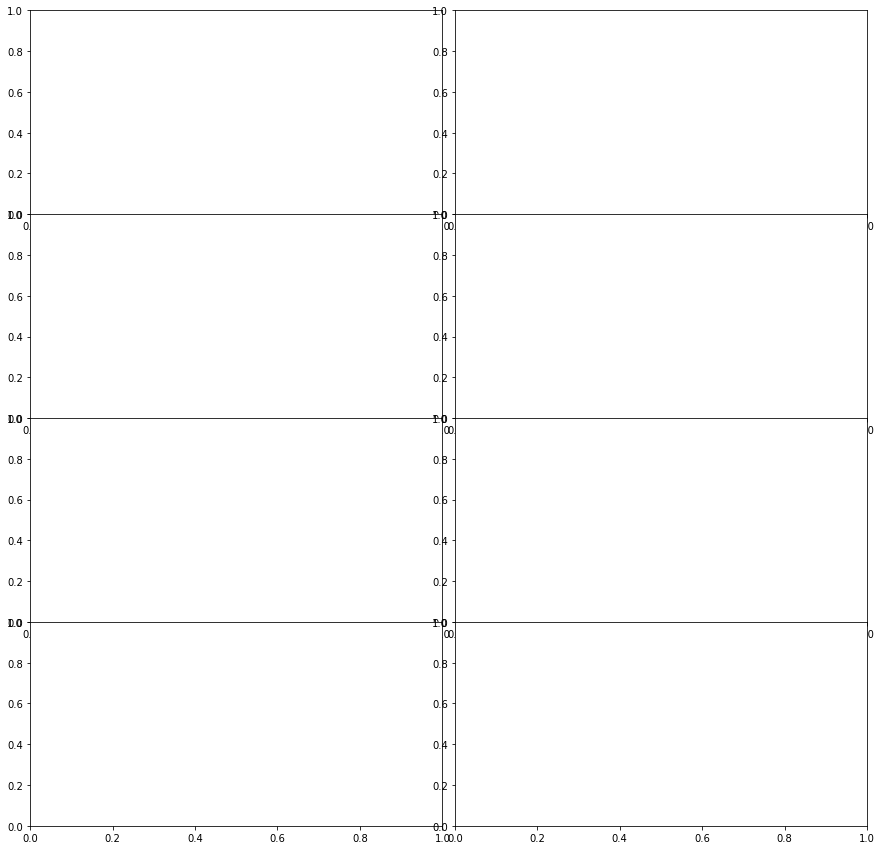

In [24]:
fig, axes = plt.subplots(4, 2, figsize=(15, 15))
plt.subplots_adjust(wspace=0.03, hspace=0.)
for i, v in enumerate(vars): 
    xy_wrap(axes[i], 0, 20, v, xlabel = True if i == 3 else False, labels=labels[i], cmap='RdBu_r')